# Table of Contents
* [Extract Traits from the VertNet Database](#Extract-Traits-from-the-VertNet-Database)
	* [Introduction](#Introduction)
		* [General Approach for Extraction](#General-Approach-for-Extraction)
		* [Constants Used During the Extraction](#Constants-Used-During-the-Extraction)
		* [Look at the Words in the Target Cells](#Look-at-the-Words-in-the-Target-Cells)
		* [Regular Expression Objects](#Regular-Expression-Objects)
	* [Sex Parsing](#Sex-Parsing)
		* [Sex Parsing Regular Expression Battery](#Sex-Parsing-Regular-Expression-Battery)
		* [Test Sex Parsing](#Test-Sex-Parsing)
	* [Life Stage Parsing](#Life-Stage-Parsing)
		* [Life Stage Parsing Regular Expression Battery](#Life-Stage-Parsing-Regular-Expression-Battery)
		* [Test Life Stage Parsing](#Test-Life-Stage-Parsing)
	* [Common Regular Expression Fragments for Both Length and Mass Trait Parsing](#Common-Regular-Expression-Fragments-for-Both-Length-and-Mass-Trait-Parsing)
	* [Total Length Parsing](#Total-Length-Parsing)
		* [Common Total Length Parsing Regular Expression Fragments](#Common-Total-Length-Parsing-Regular-Expression-Fragments)
		* [Total Length Parsing Regular Expression Battery](#Total-Length-Parsing-Regular-Expression-Battery)
		* [Test Total Length Parsing](#Test-Total-Length-Parsing)
	* [Body Mass Parsing](#Body-Mass-Parsing)
		* [Common Body Mass Parsing Regular Expression Fragments](#Common-Body-Mass-Parsing-Regular-Expression-Fragments)
		* [Body Mass Parsing Regular Expression Battery](#Body-Mass-Parsing-Regular-Expression-Battery)
		* [Test Body Mass Parsing](#Test-Body-Mass-Parsing)
	* [Extract the Traits](#Extract-the-Traits)
		* [Extract the Raw Trait Values](#Extract-the-Raw-Trait-Values)
		* [Look at Extracted Keys and Units](#Look-at-Extracted-Keys-and-Units)
		* [Conversion Factors for Total Length and Body Mass Traits](#Conversion-Factors-for-Total-Length-and-Body-Mass-Traits)
		* [Normalize the Total Length and Body Mass Traits](#Normalize-the-Total-Length-and-Body-Mass-Traits)
	* [Summarize the Results](#Summarize-the-Results)
		* [Count the Total Number of Extracts for Each Class](#Count-the-Total-Number-of-Extracts-for-Each-Class)
		* [Gather Counts by Species](#Gather-Counts-by-Species)
		* [Convert the Classes into Groups for Presentation](#Convert-the-Classes-into-Groups-for-Presentation)
		* [Summarize Counts by Species within Each Class](#Summarize-Counts-by-Species-within-Each-Class)
		* [Get the Species with the Most Counts within Class](#Get-the-Species-with-the-Most-Counts-within-Class)
		* [Plot the Species Count Summaries](#Plot-the-Species-Count-Summaries)


# Extract Traits from the VertNet Database

## Introduction

**Welcome to the thrilling world of parsing irregularly structured text!**

We're going to extract the following traits from an extract of the [VertNet database](http://vertnet.org/):
- Sex
- Life stage
- Total length (or a commonly used measure often substituted for total length: E.g. Snout-Vent Length)
- Body mass (look for common body mass substitutes too)

We are looking for the traits in these columns of the VertNet database:
- dynamicproperties (This will be the preferred column for extracting values)
- occurrenceremarks
- fieldnotes

We will append the extracted data to new columns in each row.

We're exploiting the fact that most of the data is in a structured or semi-structured format.

**Note**: This an early version and, as such, it uses an *Ad hoc* approach with regular expressions. **This will not scale to other trait extractions.** We will need to use additional techniques for this.

### General Approach for Extraction

We are going to loop through a each row in the CSV file and scan for the trait in each of the column cells. The scanning will involve an ordered battery of regular expressions for each trait. Once a trait is found for the CSV cell we will stop scanning that particular cell for the trait and move on to the next cell.  That means that we may find the same trait for a row in each of the scanned cells. For example: We may find a sex in both dynamicproperties and occurrenceremarks and we will record both. Once we have scanned all cells in a row for a trait we will then move on to scan all cells in the row for the next trait. And so on.  **The order of the regular expressions is important.**

We will add a new column for each trait being extracted. That column will contain a JSON object with an array of objects like so:

<table>
    <tr>
        <th>...rest of CSV row...</th>
        <th>autoextract_body_length</th>
        <th>...other extracted columns...</th>
    </tr>
    <tr>
        <td>orginal data is untouched</td>
        <td>{"dynamicproperties":{"key":"totalLengthInMM","units":"MM","value":"270"},
        "fieldnotes":{"key":"total length","units":"mm","value":"270.0"}}</td>
        <td>other extracted data</td>
    </tr>
    
</table>

The object will have the column we extracted the trait from as a column key. Therefore, there will be up to three fields in the object (In the example above there was nothing for the "occurrenceremarks" column.):
- key: AKA the regex key. (Two keys are a bit confusing.) This is what we're looking for to extract the value.
- value: This is a number or a number range for the value. Or a word or phrase for class values.
- units: For measurements with numbers we also try to extract the units associated with the value.

**Note**: We do not try to interpret any of the values while extracting them. We will interpret the data at a later step.

In [1]:
%matplotlib inline
import os
import sys
import csv
import json
import regex   # re expressions lack desired features
import datetime
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from cycler import cycler
from pprint import pprint

### Constants Used During the Extraction

In [2]:
# data directory
DATA_DIR = '../data/'

# The file containing the original VertNet extraction
VERTNET_FILE_NAME = os.path.join(DATA_DIR, 'vn_20151028_orems_fnotes_dprops_not_null')

# Used in file names
# now = datetime.datetime.now().strftime("_%Y%m%d_%H%M_")
BASE_FILE_NAME = VERTNET_FILE_NAME + '_'

# The file containing the parsed VertNet traits
RAW_FILE_NAME = BASE_FILE_NAME + 'raw.csv'

# The file containing the normalized VertNet traits
NORMALIZED_FILE_NAME = BASE_FILE_NAME + 'norm.csv'

# A file containing all of the raw words in the target columns -- used to search for stem words
WORDS_FILE_NAME = BASE_FILE_NAME + 'words.txt'

# We will search these VerNet columns to extract the traits
# We use the order during normalization
VERTNET_SEARCH_COLUMNS = [
    'dynamicproperties',
    'occurrenceremarks',
    'fieldnotes'
]

### Look at the Words in the Target Cells

To get an idea of what kinds of data are in the cells we will look at the different words in the cells. After examining those words, we can start to get an idea of what regular expressions to write and which words to use as anchors for the regular expressions.

In [ ]:
def get_words_in_cells(csv_dict_reader, search_columns):
    # For this, we consider dots as letters
    punctuation = regex.compile(r'[^\p{Letter}.]+')
    
    words = Counter()
    
    for row in csv_dict_reader:
        extracted_words = []
        
        for column in search_columns:
            extracted_words.extend(punctuation.split(row[column]))
    
        for word in extracted_words:
            words[word.lower()] += 1
    
    return sorted(words.keys())

In [ ]:
def get_all_words():
    with open(VERTNET_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        words = get_words_in_cells(reader
                                   , VERTNET_SEARCH_COLUMNS)

    with open(WORDS_FILE_NAME, 'w') as out_file:
        for word in words:
            out_file.write(word + '\n')


# get_all_words()  # Uncomment me to get the list of words used in the columns being searched

### Regular Expression Objects

The regular expressions require common supporting logic so they are packaged into an object. We will use an array of these objects for the actual parsing.

In [ ]:
class Regexp:
    def __init__(self, name, regexp,
                 want_array=0,
                 parse_units=False,
                 default_key=None,
                 default_units=None,
                 units_from_key=None,
                 compound_value=False):
        self.name = name
        self.regexp = regex.compile(
            regexp,
            regex.IGNORECASE | regex.VERBOSE)
        self.want_array     = want_array
        self.parse_units    = parse_units
        self.default_key    = default_key
        self.default_units  = default_units
        self.compound_value = compound_value
        self.units_from_key = units_from_key

    def _get_key_(self, match):
        key = None
        if 'key' in match.groupdict().keys():
            key = match.group('key')
        if not key:
            key = self.default_key
        return key

    def _get_value_(self, match):
        if 'value' in match.groupdict().keys():
            return match.group('value')
        return [match.group('value1'), match.group('value2')]

    def _get_units_(self, match, key):
        units = None
        if 'units' in match.groupdict().keys():
            units = match.group('units')
        if 'units1' in match.groupdict().keys():
            units = [match.group('units1'), match.group('units2')]
        if not units and key:
            u = self.units_from_key.search(key)
            if u:
                units = u.group('units')
        if not units:
            units = self.default_units
        return units

    def _get_value_array_(self, string):
        matches = self.regexp.findall(string)
        if matches and len(matches) <= self.want_array:
            return dict(key=None, value=matches)
        else:
            return None

    def matches(self, string):
        if self.want_array:
            return self._get_value_array_(string)

        match = self.regexp.search(string)
        if not match:
            return None

        parsed = dict()
        parsed['key']   = self._get_key_(match)
        parsed['value'] = self._get_value_(match)
        if self.parse_units:
            parsed['units'] = self._get_units_(match, parsed['key'])

        return parsed

We use a carefully ordered array of regular expressions to look for traits in the database. There is some logic for dealing with the entire array of regular expressions, this is captured in the following object.

In [ ]:
class RegexpBattery:
    def __init__(self, exclude_pattern=None, parse_units=False, units_from_key=None):
        self.exclude_pattern = exclude_pattern
        if exclude_pattern:
            self.exclude_pattern = regex.compile(
                exclude_pattern,
                regex.IGNORECASE | regex.VERBOSE)

        self.units_from_key = units_from_key
        if units_from_key:
            self.units_from_key = regex.compile(
                units_from_key,
                regex.IGNORECASE | regex.VERBOSE)

        self.battery     = []
        self.parse_units = parse_units

    def _excluded_(self, match):
        if self.exclude_pattern and match and isinstance(match['value'], str):
            return self.exclude_pattern.search(match['value'])
        return False
    
    def append(self, *args, **kwargs):
        regexp = Regexp(*args, **kwargs)
        self.battery.append(regexp)
        regexp.parse_units    = self.parse_units
        regexp.units_from_key = self.units_from_key
    
    def parse(self, string):
        for regexp in self.battery:
            match = regexp.matches(string)
            if match and not self._excluded_(match):
                # print(regexp.name)
                return match
        return None

[top](#Table-of-Contents)

## Sex Parsing

### Sex Parsing Regular Expression Battery

The regular expressions:
- First we look for a keyword for sex and its value. We try and get a string of words for the value by looking for a delimiter after the value.
- If no delimiter is found then just return the word that follows the keyword.
- Failing that, we look for the words "male" or "female" in the cells. Here we want to return all matches not just one so that we don't seem more sure of the value than we should.

In [ ]:
SEX = RegexpBattery(exclude_pattern=r''' ^ (?: and | was | is ) $ ''')

# Look for a key and value that is terminated with a delimiter
SEX.append(
    'sex_key_value_delimited',
    r'''
        \b (?P<key> sex)
        \W+
        (?P<value> [\w?.]+ (?: \s+ [\w?.]+ ){0,2} )
        \s* (?: [:;,"] | $ )
    '''
)

# Look for a key and value without a clear delimiter
SEX.append(
    'sex_key_value_undelimited',
    r'''
         \b (?P<key> sex) \W+ (?P<value> \w+ )
    '''
)

# Look for the words male & female
SEX.append(
    'sex_unkeyed',
    r'''
        \b (?P<value> (?: males? | females? ) (?: \s* \? )? ) \b
    ''',
    want_array=2
)

### Test Sex Parsing

In [ ]:
target = SEX

class TestSexParsing(unittest.TestCase):

    def test_sex_key_value_delimited_1(self):
        self.assertDictEqual(
            target.parse('weight=81.00 g; sex=female ? ; age=u ad.'),
            {'key': 'sex', 'value': 'female ?'})

    def test_sex_key_value_delimited_2(self):
        self.assertDictEqual(
            SEX.parse('sex=unknown ; crown-rump length=8 mm'),
            {'key': 'sex', 'value': 'unknown'})

    def test_sex_key_value_undelimited_1(self):
        self.assertDictEqual(
            target.parse('sex=F crown rump length=8 mm'),
            {'key': 'sex', 'value': 'F'})

    def test_sex_unkeyed_1(self):
        self.assertDictEqual(
            target.parse('words male female unknown more words'),
            {'key': None, 'value': ['male', 'female']})

    def test_sex_unkeyed_2(self):
        self.assertEqual(
            target.parse('words male female male more words'),
            None)

    def test_excluded_1(self):
        self.assertEqual(
            target.parse('Respective sex and msmt. in mm'),
            None)

suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestSexParsing)
unittest.TextTestRunner().run(suite)

[top](#Table-of-Contents)

## Life Stage Parsing

### Life Stage Parsing Regular Expression Battery

The regular expressions:
- First we look for a keyword for life stage and its value. We try and get a string of words for the value by looking for a delimiter after the value.
- If no delimiter is found then return known life stage phrases that follow the keyword.
- Failing that, we look for phrases that are associated with life stage.

In [ ]:
LIFE_STAGE = RegexpBattery(
    exclude_pattern=r''' ^ determin ''')

# Common regular expression fragments for parsing life stage
LIFE_STAGE_FRAGMENTS = r'''
    (?(DEFINE)
        (?P<word_chars> [\w?.\/\-]+ )
    )
'''

# Look for a key and value that is terminated with a delimiter
LIFE_STAGE.append(
    'life_stage_key_value_delimited',
    LIFE_STAGE_FRAGMENTS + r'''
        \b (?P<key> (?: life \s* stage (?: \s* remarks )? | age (?: \s* class )? ) )
           \W+
           (?P<value> (?&word_chars) (?: \s+(?&word_chars) ){0,4} ) \s*
           (?: [:;,"] | $ )
    '''
)

# Look for a key and value without a clear delimiter
LIFE_STAGE.append(
    'life_stage_key_value_undelimited',
    LIFE_STAGE_FRAGMENTS + r'''
        \b (?P<key> life \s* stage (?: \s* remarks )?
                  | age \s* class
                  | age \s* in \s* (?: hour | day ) s?
                  | age
            )
            \W+
            (?P<value> [\w?.\/\-]+ (?: \s+ (?: year | recorded ) )? )
    '''
)

# Look for common life stage phrases
LIFE_STAGE.append(
    'life_stage_no_keyword',
    LIFE_STAGE_FRAGMENTS + r'''
        (?P<value> (?: after \s+ )?
                   (?: first | second | third | fourth | hatching ) \s+
                   year )
    '''
)

### Test Life Stage Parsing

In [ ]:
target = LIFE_STAGE

class TestLifeStageParsing(unittest.TestCase):

    def test_life_stage_key_value_delimited_1(self):
        self.assertDictEqual(
            target.parse('sex=unknown ; age class=adult/juvenile'),
            {'key': 'age class', 'value': 'adult/juvenile'})

    def test_life_stage_key_value_delimited_2(self):
        self.assertDictEqual(
            target.parse('weight=81.00 g; sex=female ? ; age=u ad.'),
            {'key': 'age', 'value': 'u ad.'})

    def test_life_stage_key_value_delimited_3(self):
        self.assertDictEqual(
            target.parse('weight=5.2 g; age class=over-winter ; total length=99 mm;'),
            {'key': 'age class', 'value': 'over-winter'})

    def test_life_stage_key_value_undelimited_1(self):
        self.assertDictEqual(
            target.parse('sex=female ? ; age=1st year more than four words here'),
            {'key': 'age', 'value': '1st year'})

    def test_life_stage_no_keyword_1(self):
        self.assertDictEqual(
            target.parse('words after hatching year more words'),
            {'key': None, 'value': 'after hatching year'})

    def test_excluded_1(self):
        self.assertEqual(
            target.parse('age determined by 20-sided die'),
            None)

    def test_life_stage_no_keyword_2(self):
        self.assertDictEqual(
            target.parse('LifeStage Remarks: 5-6 wks'),
            {'key': 'LifeStage Remarks', 'value': '5-6 wks'})
        
suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestLifeStageParsing)
unittest.TextTestRunner().run(suite)

[top](#Table-of-Contents)

## Common Regular Expression Fragments for Both Length and Mass Trait Parsing

Length and Mass regular expressions use many of the same parsing fragments repeatedly. We group them here and append them to the regular expressions in the batteries.

One common abbreviation that is used in both mass and length traits is in the form of: 181-75-21-18=22. The first number is always the total length in millimeters and the last number is the body mass. The other numbers are various length measurements that we are not extracting at this time. The first number (total length) is easy to extract but the last number is typically, but not always, preceded by an equal sign. Things to be careful about when parsing this form:
- We do not want to mistake a date for this shorthand notation.
- If the last number is not preceded by an equal sign or not followed by a mass unit (which makes the parsing easy) then we will consider the last number to be a mass if there are at least 5 numbers in the sequence.
- There is also a simplifying form for the shorthand like: 83-0-17-23-fa64-35. We consider the last number after the "fa" number to be the total mass.
- We have to be careful to not mistake these shorthand notations for number ranges like 10.5-20.2

In [ ]:
MASS_LENGTH_FRAGMENTS = r'''
    (?(DEFINE)
    
        # For our purposes numbers are always positive and decimals.
        (?P<number> (?&open) (?: \d{1,3} (?: , \d{3} ){1,3} | \d+ ) (?: \. \d+ )? (?&close) [\*]? )
       
        # We also want to pull in number ranges when appropriate.
        (?P<range> (?&number) (?: \s* (?: - | to ) \s* (?&number) )? )

        # Characters that follow a keyword
        (?P<key_end>  \s* [^\w.\[\(]* \s* )
        
        # We sometimes want to guarantee no word precedes another word.
        # This cannot be done with negative look behind,
        # so we do a positive search for a separator
        (?P<no_word>  (?: ^ | [;,:"'\{\[\(]+ ) \s* )

        # Keywords that may precedes a shorthand measurement
        (?P<shorthand_words> on \s* tag
                           | specimens?
                           | catalog
                           | measurements (?: \s+ [\p{Letter}]+)
                           | tag \s+ \d+ \s* =? (?: male | female)? \s* ,
                           | meas [.,]? (?: \s+ \w+ \. \w+ \. )?
        )
        
        # Common keyword misspellings that precede shorthand measurement
        (?P<shorthand_typos>  mesurements | Measurementsnt )
        
        # Keys where we need units to know if it's for mass or length
        (?P<key_units_req> measurements? | body | total )
        
        # Characters that separate shorthand values
        (?P<shorthand_sep> [:\/\-\s] )
        
        # Used in shorthand notation for unknown values
        (?P<shorthand_unknown> [?x] )

        # Look for an optional dash or space character
        (?P<dash>     [\s\-]? )
        (?P<dash_req> [\s\-]  )
        
        # Look for an optional dot character
        (?P<dot> \.? )
        
        # Numbers are sometimes surrounded by brackets or parentheses
        # Don't worry about matching the opening and closing brackets
        (?P<open>  [\(\[\{]? )
        (?P<close> [\)\]\}]? )
    )
'''

[top](#Table-of-Contents)

## Total Length Parsing

### Common Total Length Parsing Regular Expression Fragments

In [ ]:
LENGTH_FRAGMENTS = MASS_LENGTH_FRAGMENTS + r'''
    (?(DEFINE)

        # Look for a shorthand total length. Make sure this isn't a date
        (?P<len_shorthand> (?&dash_req) (?: (?&number) | (?&shorthand_unknown) )
                           (?: (?&shorthand_sep)
                               (?: (?&number) | (?&shorthand_unknown) ) ){2,}
        )

        # The "European" version of the shorthand length
        (?P<len_shorthand_euro> (?&dash_req) (?: (?&number) | (?&shorthand_unknown) )
                                (?: (?&shorthand_sep)
                                (?: (?<! [\w\-] ) (?&number) | (?&shorthand_unknown) )
                                [\p{Letter}]{0,3} ){2,}
        )

        # Keys that indicate we have a total length
        (?P<total_len_key> total  (?&dash) length (?&dash) in (?&dash) mm
                         | length (?&dash) in     (?&dash) millimeters
                         | (?: total | max | standard ) (?&dash) lengths?
                         | meas (?: [a-z]* )? (?&dot) : \s* L
                         | s (?&dot) l (?&dot)
                         | label (?&dot) \s* lengths?
        )

        # Snout-vent length is sometimes used as a proxy for total length in some groups
        (?P<svl_len_key> snout  (?&dash) vent   (?&dash) lengths? (?: (?&dash) in (?&dash) mm )?
                       | s (?&dot) v (?&dot) (:? l (?&dot) )?
                       | snout \s+ vent \s+ lengths?
        )

        # Other keys that may be used as a proxy for total length for some groups
        (?P<other_len_key> head  (?&dash) body (?&dash) length (?&dash) in (?&dash) millimeters
                         | (?: fork | mean | body ) (?&dash) lengths?
                         | t [o.]? l (?&dot) _?
        )

        # Ambiguous length keys
        (?P<len_key_ambiguous> lengths? | tag )

        # Abbreviations for total length
        (?P<len_key_abbrev> t (?&dot) o? l (?&dot) | s (?&dot) l (?&dot) )

        # For when the key is a suffix like: 44 mm TL
        (?P<len_key_suffix> (?: in \s* )? (?&len_key_abbrev) )

        # Gather all length key types
        (?P<all_len_keys> (?&total_len_key)
                        | (?&svl_len_key)
                        | (?&other_len_key)
                        | (?&len_key_ambiguous)
                        | (?&key_units_req)
                        | (?&shorthand_words)
                        | (?&shorthand_typos)
        )

        # Length keys found in phrases
        (?P<len_in_phrase> (?: total \s+ length | snout \s+ vent \s+ length | standard \s+ length ) s? )

        # Length unit words
        (?P<len_units_word> (?: meter | millimeter | centimeter | foot | feet | inch e? ) s? )

        # Length unit abbreviations
        (?P<len_units_abbrev> (?: [cm] (?&dot) m | in | ft ) (?&dot) s? )

        # All length units
        (?P<len_units> (?&len_units_word) | (?&len_units_abbrev) )

        # Used for parsing forms like: 2 ft 4 inches
        (?P<len_foot> (?: foot | feet | ft ) s? (?&dot) )
        (?P<len_inch> (?: inch e? | in )     s? (?&dot) )
    )
'''

### Total Length Parsing Regular Expression Battery

This array of regular expressions is ordered so that it will capture the most values as possible, not for speed.

In [ ]:
TOTAL_LENGTH = RegexpBattery(parse_units=True, units_from_key=r''' (?P<units> mm | millimeters ) $ ''')

# Look for a pattern like: total length: 4 ft 8 in
TOTAL_LENGTH.append(
    'en_len',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key> (?&all_len_keys))? (?&key_end)?
           (?P<value1> (?&range))    \s*
           (?P<units1> (?&len_foot)) \s*
           (?P<value2> (?&range))    \s*
           (?P<units2> (?&len_inch))
    ''',
    default_key='_english_',
    compound_value=2
)

# Look for total key, number (not a range) and optional units
# Like: total length = 10.5 mm
TOTAL_LENGTH.append(
    'total_len_key_num',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&total_len_key)) (?&key_end)
           (?P<value> (?&number)) (?! [\d\-\.] ) \s*
           (?P<units> (?&len_units))?
    ''',
    default_units='_mm_'
)

# Look for these secondary length keys next but allow a range
TOTAL_LENGTH.append(
    'other_len_key',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&other_len_key)) (?&key_end)
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    '''
)

# Look for keys where the units are required
TOTAL_LENGTH.append(
    'key_units_req',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key> (?&key_units_req)) (?&key_end)
        (?P<value> (?&range)) \s*
        (?P<units> (?&len_units))
    '''
)

# Look for a length in a phrase
TOTAL_LENGTH.append(
    'len_in_phrase',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&len_in_phrase)) \D{1,32}
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    '''
)

# These ambiguous keys have a suffix that disambiguate them
TOTAL_LENGTH.append(
    'len_key_ambiguous_units',
    LENGTH_FRAGMENTS + r'''
        (?&no_word) (?&len_key_ambiguous) (?&key_end)
        (?P<value> (?&range)) \s*
        (?P<units> (?&len_units))? \s*
        (?P<key>   (?&len_key_suffix))
    '''
)

# These keys require units to disambiguate what is being measured
TOTAL_LENGTH.append(
    'len_key_ambiguous_units',
    LENGTH_FRAGMENTS + r'''
        (?&no_word)
        (?P<key>   (?&len_key_ambiguous)) (?&key_end)
        (?P<value> (?&range)) \s*
        (?P<units> (?&len_units))
    '''
)

# An out of order parse: tol (mm) 20-25
TOTAL_LENGTH.append(
    'len_key_abbrev',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&len_key_abbrev)) \s*
           (?&open)  \s* (?P<units> (?&len_units)) \s* (?&close) \s*
           (?P<value> (?&range))
    '''
)

# This parse puts the key at the end: 20-25 mm TL
TOTAL_LENGTH.append(
    'len_key_suffix',
    LENGTH_FRAGMENTS + r'''
        \b (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))? \s*
           (?P<key>   (?&len_key_suffix))
    '''
)

# Length is in shorthand notation
TOTAL_LENGTH.append(
    'len_shorthand',
    LENGTH_FRAGMENTS + r'''
        \b (?: (?P<key> (?&all_len_keys)) (?&key_end) )?
           (?P<value>   (?&number))
           (?&len_shorthand)
    ''',
    default_units='_mm_',
    default_key='_shorthand_'
)

# A shorthand notation with some abbreviations in it
TOTAL_LENGTH.append(
    'len_shorthand_euro',
    LENGTH_FRAGMENTS + r'''
        \b (?: (?P<key> (?&all_len_keys)) (?&key_end) )?
           [a-z]*
           (?P<value>   (?&number))
           (?&len_shorthand_euro)
    ''',
    default_units='_mm_',
    default_key='_shorthand_'
)

# Now we can look for the total length, RANGE, optional units
# See 'total_len_key_num' above
TOTAL_LENGTH.append(
    'total_len_key',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&total_len_key)) (?&key_end)
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    ''',
    default_units='_mm_'
)

# We will now allow an ambiguous key if it is not preceded by another word
TOTAL_LENGTH.append(
    'len_key_ambiguous',
    LENGTH_FRAGMENTS + r'''
        (?&no_word)
        (?P<key>   (?&len_key_ambiguous)) (?&key_end)
        (?P<value> (?&range))
    '''
)

# Look for snout-vent length keys
TOTAL_LENGTH.append(
    'svl_len_key',
    LENGTH_FRAGMENTS + r'''
        \b (?P<key>   (?&svl_len_key)) (?&key_end)
           (?P<value> (?&range)) \s*
           (?P<units> (?&len_units))?
    '''
)

### Test Total Length Parsing

In [ ]:
target = TOTAL_LENGTH

class TestTotalLengthParsing(unittest.TestCase):

    def test_1(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"123" };'),
            {'key': 'totalLengthInMM', 'value': '123', 'units': 'MM'})
    
    def test_2(self):
        self.assertDictEqual(
            target.parse('measurements: ToL=230;TaL=115;HF=22;E=18; total length=230 mm; tail length=115 mm;'),
            {'key': 'total length', 'value': '230', 'units': 'mm'})
    
    def test_3(self):
        self.assertEqual(
            target.parse('sex=unknown ; crown-rump length=8 mm'),
            None)
    
    def test_4(self):
        self.assertEqual(
            target.parse('left gonad length=10 mm; right gonad length=10 mm;'),
            None)
    
    def test_5(self):
        self.assertDictEqual(
            target.parse('"{"measurements":"308-190-45-20" }"'),
            {'key': 'measurements', 'value': '308', 'units': '_mm_'})
    
    def test_6(self):
        self.assertDictEqual(
            target.parse('308-190-45-20'),
            {'key': '_shorthand_', 'value': '308', 'units': '_mm_'})
    
    def test_7(self):
        self.assertDictEqual(
            target.parse('{"measurements":"143-63-20-17=13 g" }'),
            {'key': 'measurements', 'value': '143', 'units': '_mm_'})
    
    def test_8(self):
        self.assertDictEqual(
            target.parse('143-63-20-17=13'),
            {'key': '_shorthand_', 'value': '143', 'units': '_mm_'})
    
    def test_9(self):
        self.assertDictEqual(
            target.parse('snout-vent length=54 mm; total length=111 mm; tail length=57 mm; weight=5 g'),
            {'key': 'total length', 'value': '111', 'units': 'mm'})
    
    def test_10(self):
        self.assertDictEqual(
            target.parse('unformatted measurements=Verbatim weight=X;ToL=230;TaL=115;HF=22;E=18;'
                         ' total length=230 mm; tail length=115 mm;'),
            {'key': 'total length', 'value': '230', 'units': 'mm'})
    
    def test_11(self):
        self.assertDictEqual(
            target.parse('** Body length =345 cm; Blubber=1 cm '),
            {'key': 'Body length', 'value': '345', 'units': 'cm'})

    def test_12(self):
        self.assertDictEqual(
            target.parse('t.l.= 2 feet 3.1 - 4.5 inches '),
            {'key': 't.l.', 'value': ['2', '3.1 - 4.5'], 'units': ['feet', 'inches']})

    def test_13(self):
        self.assertDictEqual(
            target.parse('2 ft. 3.1 - 4.5 in. '),
            {'key': '_english_', 'value': ['2', '3.1 - 4.5'], 'units': ['ft.', 'in.']})

    def test_14(self):
        self.assertDictEqual(
            target.parse('total length= 2 ft.'),
            {'key': 'total length', 'value': '2', 'units': 'ft.'})

    def test_15(self):
        self.assertDictEqual(
            target.parse('AJR-32   186-102-23-15  15.0g'),
            {'key': '_shorthand_', 'value': '186', 'units': '_mm_'})

    def test_16(self):
        self.assertDictEqual(
            target.parse('length=8 mm'),
            {'key': 'length', 'value': '8', 'units': 'mm'})

    def test_17(self):
        self.assertDictEqual(
            target.parse('another; length=8 mm'),
            {'key': 'length', 'value': '8', 'units': 'mm'})
    
    def test_18(self):
        self.assertDictEqual(
            target.parse('another; TL_120, noise'),
            {'key': 'TL_', 'value': '120', 'units': None})
    
    def test_19(self):
        self.assertDictEqual(
            target.parse('another; TL - 101.3mm, noise'),
            {'key': 'TL', 'value': '101.3','units': 'mm'})
     
    def test_20(self):
        self.assertDictEqual(
           target.parse('before; TL153, after'),
            {'key': 'TL', 'value': '153', 'units': None})

    def test_21(self):
        self.assertDictEqual(
            target.parse('before; Total length in catalog and specimen tag as 117, after'),
            {'key': 'Total length', 'value': '117', 'units': None})
    
    def test_22(self):
        self.assertDictEqual(
            target.parse('before Snout vent lengths range from 16 to 23 mm. after'),
            {'key': 'Snout vent lengths', 'value': '16 to 23', 'units': 'mm.'})
    
    def test_23(self):
        self.assertDictEqual(
            target.parse('Size=13 cm TL'),
            {'key': 'TL', 'value': '13', 'units': 'cm'})
    
    def test_24(self):
        self.assertDictEqual(
            target.parse('det_comments:31.5-58.3inTL'),
            {'key': 'TL', 'value': '31.5-58.3', 'units': 'in'})
    
    def test_25(self):
        self.assertDictEqual(
            target.parse('SVL52mm'),
            {'key': 'SVL', 'value': '52', 'units': 'mm'})
    
    def test_26(self):
        self.assertDictEqual(
            target.parse('snout-vent length=221 mm; total length=257 mm; tail length=36 mm'),
            {'key': 'total length', 'value': '257', 'units': 'mm'})
    
    def test_27(self):
        self.assertDictEqual(
            target.parse('SVL 209 mm, total 272 mm, 4.4 g.'),
            {'key': 'total', 'value': '272', 'units': 'mm'})
    
    def test_28(self):
        self.assertDictEqual(
            target.parse('{"time collected":"0712-0900", "length":"12.0" }'),
            {'key': 'length', 'value': '12.0', 'units': None})
    
    def test_29(self):
        self.assertDictEqual(
            target.parse('{"time collected":"1030", "water depth":"1-8", "bottom":"abrupt lava '
                         'cliff dropping off to sand at 45 ft.", "length":"119-137" }'),
            {'key': 'length', 'value': '119-137', 'units': None})
    
    def test_30(self):
        self.assertDictEqual(
            target.parse('TL (mm) 44,SL (mm) 38,Weight (g) 0.77 xx'),
            {'key': 'TL', 'value': '44', 'units': 'mm'})
    
    def test_31(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"270-165-18-22-31", '),
            {'key': 'totalLengthInMM', 'value': '270', 'units': 'MM'})
    
    def test_32(self):
        self.assertDictEqual(
            target.parse('{"length":"20-29" }'),
            {'key': 'length', 'value': '20-29', 'units': None})
    
    def test_33(self):
        self.assertDictEqual(
            target.parse('field measurements on fresh dead specimen were 157-60-20-19-21g'),
            {'key': '_shorthand_', 'value': '157', 'units': '_mm_'})

    def test_34(self):
        self.assertDictEqual(
            target.parse('f age class: adult; standard length: 63-107mm'),
            {'key': 'standard length', 'value': '63-107', 'units': 'mm'})

    def test_35(self):
        self.assertEqual(
            target.parse('Rehydrated in acetic acid 7/1978-8/1987.'),
            None)

    def test_36(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18.0-21.5mm'),
            {'key': 'standard length', 'value': '18.0-21.5', 'units': 'mm'})

    def test_37(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18-21.5mm'),
            {'key': 'standard length', 'value': '18-21.5', 'units': 'mm'})

    def test_38(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18.0-21mm'),
            {'key': 'standard length', 'value': '18.0-21', 'units': 'mm'})

    def test_39(self):
        self.assertDictEqual(
            target.parse('age class: adult; standard length: 18-21mm'),
            {'key': 'standard length', 'value': '18-21', 'units': 'mm'})
    
    def test_40(self):
        self.assertEqual(
            target.parse("Specimen #'s - 5491,5492,5498,5499,5505,5526,5527,5528,5500,"
                         "5507,5508,5590,5592,5595,5594,5593,5596,5589,5587,5586,5585"),
            None)

    def test_41(self):
        self.assertEqual(
            target.parse('20-28mm SL'),
            {'key': 'SL', 'value': '20-28', 'units': 'mm'})

    def test_42(self):
        self.assertEqual(
            target.parse('29mm SL'),
            {'key': 'SL', 'value': '29', 'units': 'mm'})
    
    def test_43(self):
        self.assertEqual(
            target.parse('{"measurements":"159-?-22-16=21.0" }'),
            {'key': 'measurements', 'value': '159', 'units': '_mm_'})

    def test_44(self):
        self.assertEqual(
            target.parse('c701563b-dbd9-4500-184f-1ad61eb8da11'),
            None)

    def test_45(self):
        self.assertEqual(
            target.parse('Meas: L: 21.0'),
            {'key': 'Meas: L', 'value': '21.0', 'units': '_mm_'})

    def test_46(self):
        self.assertEqual(
            target.parse('Meas: L: 21.0 cm'),
            {'key': 'Meas: L', 'value': '21.0', 'units': 'cm'})

    def test_47(self):
        self.assertEqual(
            target.parse('LABEL. LENGTH 375 MM.'),
            {'key': 'LABEL. LENGTH', 'value': '375', 'units': 'MM.'})

    def test_48(self):
        self.assertEqual(
            target.parse('SL=12mm'),
            {'key': 'SL', 'value': '12', 'units': 'mm'})

    def test_49(self):
        self.assertEqual(
            target.parse('Size=SL 12-14 mm'),
            {'key': 'SL', 'value': '12-14', 'units': 'mm'})

    def test_50(self):
        self.assertEqual(
            target.parse('SV 1.2'),
            {'key': 'SV', 'value': '1.2', 'units': None})

    def test_51(self):
        self.assertEqual(
            target.parse(' Length: 123 mm SL'),
            {'key': 'SL', 'value': '123', 'units': 'mm'})

    def test_52(self):
        self.assertEqual(
            target.parse(' Length: 12-34 mmSL'),
            {'key': 'SL', 'value': '12-34', 'units': 'mm'})

    def test_53(self):
        self.assertEqual(
            target.parse('Measurements: L: 21.0 cm'),
            {'key': 'Measurements: L', 'value': '21.0', 'units': 'cm'})


suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestTotalLengthParsing)
unittest.TextTestRunner().run(suite)

[top](#Table-of-Contents)

## Body Mass Parsing

### Common Body Mass Parsing Regular Expression Fragments

In [ ]:
MASS_FRAGMENTS = MASS_LENGTH_FRAGMENTS + r'''
    (?(DEFINE)

        # Used to indicate that the next measurement in a shorthand notation is total mass
        (?P<wt_shorthand_sep> [=\s\-]+ )

        # Shorthand notation
        (?P<wt_shorthand> (?: (?: (?&number) | (?&shorthand_unknown) ) (?&shorthand_sep) ){3,}
                          (?: (?&number) | (?&shorthand_unknown) ) (?&wt_shorthand_sep) )

        # Shorthand notation requiring units
        (?P<wt_shorthand_req> (?: (?: (?&number) | (?&shorthand_unknown) ) (?&shorthand_sep) ){4,} )

        # A common shorthand notation
        (?P<wt_shorthand_euro> (?: (?&number) | (?&shorthand_unknown) ) hb
                               (?: (?&shorthand_sep) (?: (?<! [\w\-] ) (?&number)
                                 | (?&shorthand_unknown) )[a-z]* ){4,} = )

        # Keywords for total mass
        (?P<total_wt_key> weightingrams | massingrams
                        | (?: body | full | observed | total ) (?&dot) \s* (?&wt_key_word)
        )

        # Keywords often used for total mass
        (?P<other_wt_key> (?: dead | live ) (?&dot) \s* (?&wt_key_word) )

        #  Weight keyword
        (?P<wt_key_word> weights?
                       | weigh (?: s | ed | ing )
                       | mass
                       | w (?&dot) t s? (?&dot)
        )

        # Gather all weight keys
        (?P<all_wt_keys>  (?&total_wt_key)  | (?&other_wt_key) | (?&wt_key_word)
                       |  (?&key_units_req) | (?&shorthand_words) | (?&shorthand_typos))

        # Look for phrases with the total weight
        (?P<wt_in_phrase> total \s+ (?&wt_key_word) )

        # Mass unit words
        (?P<wt_units_word> (?: gram | milligram | kilogram | pound | ounce ) s? )

        # Mass unit abbreviations
        (?P<wt_units_abbrev> (?: m (?&dot) g | k (?&dot) g | g[mr]? | lb | oz ) s? (?&dot) )

        # All mass units
        (?P<wt_units> (?&wt_units_word) | (?&wt_units_abbrev) )

        # Use to parse forms like: 2 lbs 4 oz.
        (?P<wt_pound> (?: pound | lb ) s? (?&dot) )
        (?P<wt_ounce> (?: ounce | oz ) s? (?&dot) )
    )
'''

### Body Mass Parsing Regular Expression Battery

This array of regular expressions is ordered so that it will capture the most values as possible, not for speed.

In [ ]:
BODY_MASS = RegexpBattery(parse_units=True, units_from_key=r''' (?P<units> grams ) $ ''')

# Look for a pattern like: body mass: 4 lbs 8 oz
BODY_MASS.append(
    'en_wt',
    MASS_FRAGMENTS + r'''
         \b (?P<key>    (?&all_wt_keys))? (?&key_end)?
            (?P<value1> (?&range))  \s*
            (?P<units1> (?&wt_pound))  \s*
            (?P<value2> (?&range))  \s*
            (?P<units2> (?&wt_ounce))
    ''',
    default_key='_english_',
    compound_value=2
)

# Look for body mass with a total weight key and optional units
BODY_MASS.append(
    'total_wt_key',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&total_wt_key)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    '''
)

# Look for these secondary body mass keys next
BODY_MASS.append(
    'other_wt_key',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&other_wt_key)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    '''
)

# Look for keys where the units are required
BODY_MASS.append(
    'key_units_req',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&key_units_req)) (?&key_end)
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))
    '''
)

# Look for the body mass in a phrase
BODY_MASS.append(
    'wt_in_phrase',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&wt_in_phrase)) \D{1,32}
            (?P<value> (?&range)) \s*
            (?P<units> (?&wt_units))?
    '''
)

# An out of order parse: body mass (g) 20-25
BODY_MASS.append(
    'wt_key_word',
    MASS_FRAGMENTS + r'''
         \b (?P<key>   (?&wt_key_word)) \s*
            (?&open) \s* (?P<units> (?&wt_units)) \s* (?&close) \s*
            (?P<value> (?&range))
    '''
)

# These keys require units to disambiguate what is being measured
BODY_MASS.append(
    'wt_key_word_req',
    MASS_FRAGMENTS + r'''
         (?P<key>   (?&wt_key_word)) (?&key_end)
         (?P<value> (?&range)) \s*
         (?P<units> (?&wt_units))
    '''
)

# Body mass is in shorthand notation
BODY_MASS.append(
    'wt_shorthand',
    MASS_FRAGMENTS + r'''
         \b (?: (?P<key> (?&all_wt_keys)) (?&key_end) )?
            (?&wt_shorthand) \s*
            (?P<value> (?&number)) \s*
            (?P<units> (?&wt_units))?
    ''',
    default_key='_shorthand_'
)

# Body mass is in shorthand notation (units required)
BODY_MASS.append(
    'wt_shorthand_req',
    MASS_FRAGMENTS + r'''
         \b (?: (?P<key> (?&all_wt_keys)) (?&key_end) )?
            (?&wt_shorthand_req) \s*
            (?P<value> (?&number)) \s*
            (?P<units> (?&wt_units))
    ''',
    default_key='_shorthand_'
)

# A shorthand notation with some abbreviations in it
BODY_MASS.append(
    'wt_shorthand_euro',
    MASS_FRAGMENTS + r'''
         \b (?: (?P<key> (?&all_wt_keys)) (?&key_end) )?
            (?&wt_shorthand_euro) \s*
            (?P<value> (?&number)) \s*
            (?P<units> (?&wt_units))?
    ''',
    default_key='_shorthand_'
)

# A notation using 'fa'. It can be shorter than the other shorthand notations
BODY_MASS.append(
    'wt_fa',
    MASS_FRAGMENTS + r'''
         fa \d* -
         (?P<value> (?&number)) \s*
         (?P<units> (?&wt_units))?
    ''',
    default_key='_shorthand_'
)

# Now we can look for the body mass, RANGE, optional units
BODY_MASS.append(
    'wt_key_ambiguous',
    MASS_FRAGMENTS + r'''
         (?P<key>   (?&wt_key_word)) (?&key_end)
         (?P<value> (?&range)) \s*
         (?P<units> (?&wt_units))?
    '''
)

### Test Body Mass Parsing

In [ ]:
target = BODY_MASS

class TestBodyMassParsing(unittest.TestCase):

    def test_1(self):
        self.assertDictEqual(
            target.parse('762-292-121-76 2435.0g'),
            {'key': '_shorthand_', 'value': '2435.0', 'units': 'g'})

    def test_2(self):
        self.assertDictEqual(
            target.parse('TL (mm) 44,SL (mm) 38,Weight (g) 0.77 xx'),
            {'key': 'Weight', 'value': '0.77', 'units': 'g'})

    def test_3(self):
        self.assertDictEqual(
            target.parse('Note in catalog: Mus. SW Biol. NK 30009; 91-0-17-22-62g'),
            {'key': '_shorthand_', 'value': '62', 'units': 'g'})

    def test_4(self):
        self.assertDictEqual(
            target.parse('body mass=20 g'),
            {'key': 'body mass', 'value': '20', 'units': 'g'})

    def test_5(self):
        self.assertDictEqual(
            target.parse('2 lbs. 3.1 - 4.5 oz '),
            {'key': '_english_', 'value': ['2', '3.1 - 4.5'], 'units': ['lbs.', 'oz']})

    def test_6(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"x", "earLengthInMM":"20", "weight":"[139.5] g" }'),
            {'key': 'weight', 'value': '[139.5]', 'units': 'g'})

    def test_7(self):
        self.assertDictEqual(
            target.parse('{"fat":"No fat", "gonads":"Testes 10 x 6 mm.", "molt":"No molt",'
                         ' "stomach contents":"Not recorded", "weight":"94 gr."'),
            {'key': 'weight', 'value': '94', 'units': 'gr.'})

    def test_8(self):
        self.assertDictEqual(
            target.parse('Note in catalog: 83-0-17-23-fa64-35g'),
            {'key': '_shorthand_', 'value': '35', 'units': 'g'})

    def test_9(self):
        self.assertDictEqual(
            target.parse('{"measurements":"20.2g, SVL 89.13mm" }'),
            {'key': 'measurements', 'value': '20.2', 'units': 'g'})

    def test_10(self):
        self.assertDictEqual(
            target.parse('Body: 15 g'),
            {'key': 'Body', 'value': '15', 'units': 'g'})

    def test_11(self):
        self.assertDictEqual(
            target.parse('82-00-15-21-tr7-fa63-41g'),
            {'key': '_shorthand_', 'value': '41', 'units': 'g'})

    def test_12(self):
        self.assertDictEqual(
            target.parse('weight=5.4 g; unformatted measurements=77-30-7-12=5.4'),
            {'key': 'weight', 'value': '5.4', 'units': 'g'})

    def test_13(self):
        self.assertDictEqual(
            target.parse('unformatted measurements=77-30-7-12=5.4; weight=5.4;'),
            {'key': 'measurements', 'value': '5.4', 'units': None})

    def test_14(self):
        self.assertDictEqual(
            target.parse('{"totalLengthInMM":"270-165-18-22-31", '),
            {'key': '_shorthand_', 'value': '31', 'units': None})

    def test_15(self):
        self.assertDictEqual(
            target.parse('{"measurements":"143-63-20-17=13 g" }'),
            {'key': 'measurements', 'value': '13', 'units': 'g'})

    def test_16(self):
        self.assertDictEqual(
            target.parse('143-63-20-17=13'),
            {'key': '_shorthand_', 'value': '13', 'units': None})

    def test_17(self):
        self.assertDictEqual(
            target.parse('reproductive data: Testes descended -10x7 mm; sex: male;'
                         ' unformatted measurements: 181-75-21-18=22 g'),
            {'key': 'measurements', 'value': '22', 'units': 'g'})

    def test_18(self):
        self.assertDictEqual(
            target.parse('{ "massInGrams"="20.1" }'),
            {'key': 'massInGrams', 'value': '20.1', 'units': 'Grams'})

    def test_19(self):
        self.assertDictEqual(
            target.parse(' {"gonadLengthInMM_1":"10", "gonadLengthInMM_2":"6", "weight":"1,192.0" }'),
            {'key': 'weight', 'value': '1,192.0', 'units': None})

    def test_20(self):
        self.assertDictEqual(
            target.parse('"weight: 20.5-31.8'),
            {'key': 'weight', 'value': '20.5-31.8', 'units': None})

    def test_21(self):
        self.assertDictEqual(
            target.parse('"weight: 20.5-32'),
            {'key': 'weight', 'value': '20.5-32', 'units': None})

    def test_22(self):
        self.assertDictEqual(
            target.parse('"weight: 21-31.8'),
            {'key': 'weight', 'value': '21-31.8', 'units': None})

    def test_23(self):
        self.assertDictEqual(
            target.parse('"weight: 21-32'),
            {'key': 'weight', 'value': '21-32', 'units': None})

    def test_24(self):
        self.assertEqual(
            target.parse("Specimen #'s - 5491,5492,5498,5499,5505,5526,5527,5528,5500,5507,5508,5590,"
                         "5592,5595,5594,5593,5596,5589,5587,5586,5585"),
            None)

    def test_25(self):
        self.assertDictEqual(
            target.parse('weight=5.4 g; unformatted measurements=77-x-7-12=5.4'),
            {'key': 'weight', 'value': '5.4', 'units': 'g'})

    def test_26(self):
        self.assertEqual(
            target.parse('c701563b-dbd9-4500-184f-1ad61eb8da11'),
            None)


suite = unittest.defaultTestLoader.loadTestsFromTestCase(TestBodyMassParsing)
unittest.TextTestRunner().run(suite)

[top](#Table-of-Contents)

## Extract the Traits

### Extract the Raw Trait Values

** Warning: This function will take hours to run given a large dataset (millions of records).**

This function uses the regular expression batteries to parse the VertNet traits.

In [ ]:
# The new columns we will put the raw (unnormalized) extracted data into
# Along with the regular expression batter used to parse the value
raw_trait_columns = [
    dict(column='autoextract_sex',          battery=SEX),
    dict(column='autoextract_life_stage',   battery=LIFE_STAGE),
    dict(column='autoextract_total_length', battery=TOTAL_LENGTH),
    dict(column='autoextract_body_mass',    battery=BODY_MASS)
]

# Used to reduce whitespace. We want multiple spaces but not too many
WS_SPLIT = regex.compile(r'\s\s\s+')


def extract_raw_traits():
    with open(VERTNET_FILE_NAME, 'r') as in_file, open(RAW_FILE_NAME, 'w') as out_file:
        reader  = csv.DictReader(in_file)
        headers = reader.fieldnames + [c['column'] for c in raw_trait_columns]
        writer  = csv.DictWriter(out_file, headers)
        writer.writeheader()
        for row in reader:
            for r in raw_trait_columns:
                cell = {}
                for v in VERTNET_SEARCH_COLUMNS:
                    string = row[v]
                    string = '  '.join(WS_SPLIT.split(string.strip()))
                    trait  = r['battery'].parse(string)
                    if trait:
                        cell[v] = trait
                if cell:
                    row[r['column']] = json.dumps(cell)
            writer.writerow(row)

# This step may take hours to run
# extract_raw_traits()  # Uncomment me to run the extractions

### Look at Extracted Keys and Units

In [ ]:
extracted_words = [
    dict(column='autoextract_total_length', json_field='key'),
    dict(column='autoextract_total_length', json_field='units'),
    dict(column='autoextract_body_mass',    json_field='key'),
    dict(column='autoextract_body_mass',    json_field='units')
]


def get_extracted_word_counts(column_name, json_field):
    cnt = Counter()
    with open(RAW_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        for row in reader:
            cell = row[column_name]
            if not cell:
                continue
            jcell = json.loads(cell)
            for key, obj in jcell.items():
                if isinstance(obj[json_field], list):
                    word = ' '.join(obj[json_field])
                else:
                    word = obj[json_field]
                if word:
                    cnt[word.lower()] += 1
    return cnt


def get_extracted_words():
    for target in extracted_words:
        words = get_extracted_word_counts(target['column'], target['json_field'])
        out_file_name = '{}{}_{}.txt'.format(BASE_FILE_NAME, target['column'],  target['json_field'])
        with open(out_file_name, 'w') as out_file:
            for word, n in sorted(words.items()):
                out_file.write(word + '\n')


# get_extracted_words()  # Uncomment me to get the extracted words

### Conversion Factors for Total Length and Body Mass Traits

After looking at the output from the extracted keys and units above, these are the length search keys we found and their normalized equivalents.

In [ ]:
LEN_KEY = {
    '_english_'                   : 'total length',
    '_shorthand_'                 : 'total length',
    'body'                        : 'head-body length',
    'body length'                 : 'head-body length',
    'catalog'                     : 'total length',
    'fork length'                 : 'fork length',
    'forklength'                  : 'fork length',
    'headbodylengthinmillimeters' : 'head-body length',
    'label length'                : 'total length',
    'label. length'               : 'total length',
    'label.length'                : 'total length',
    'length'                      : 'total length',
    'lengthinmillimeters'         : 'total length',
    'lengths'                     : 'total length',
    'max length'                  : 'total length',
    'maxlength'                   : 'total length',
    'mean length'                 : 'total length',
    'meas'                        : 'total length',
    'meas,'                       : 'total length',
    'meas.'                       : 'total length',
    'meas. h.b.'                  : 'head-body length',
    'meas: l'                     : 'total length',
    'measurement'                 : 'total length',
    'measurements'                : 'total length',
    'measurements are'            : 'total length',
    'measurements made'           : 'total length',
    'measurements of'             : 'total length',
    'measurements questionable'   : 'total length',
    'measurements read'           : 'total length',
    'measurements reads'          : 'total length',
    'measurements: l'             : 'total length',
    'measurementsnt'              : 'total length',
    'mesurements'                 : 'total length',
    'on tag'                      : 'total length',
    's.l'                         : 'standard length',
    's.l.'                        : 'standard length',
    's.v.'                        : 'snout-vent length',
    'sl'                          : 'standard length',
    'sl.'                         : 'standard length',
    'snout vent length'           : 'snout-vent length',
    'snout vent lengths'          : 'snout-vent length',
    'snout-vent length'           : 'snout-vent length',
    'snout-vent lengths'          : 'snout-vent length',
    'snoutventlengthinmm'         : 'snout-vent length',
    'specimen'                    : 'total length',
    'specimens'                   : 'total length',
    'standard length'             : 'standard length',
    'sv'                          : 'snout-vent length',
    'svl'                         : 'snout-vent length',
    'svl.'                        : 'snout-vent length',
    't.l'                         : 'total length',
    't.l.'                        : 'total length',
    'tag'                         : 'total length',
    'tl'                          : 'total length',
    'tl.'                         : 'total length',
    'tl_'                         : 'total length',
    'tol'                         : 'total length',
    'total'                       : 'total length',
    'total length'                : 'total length',
    'total length in mm'          : 'total length',
    'total lengths'               : 'total length',
    'totallength'                 : 'total length',
    'totallengthinmm'             : 'total length',
}

After looking at the output from the extracted keys and units above, these are the length units we found and their normalized equivalents. We are normalizing to millimeters.

In [ ]:
LEN_UNITS = {
    ''             : 1.0,
    '_mm_'         : 1.0,
    'c.m.'         : 10.0,
    'centimeters'  : 10.0,
    'cm'           : 10.0,
    'cm.'          : 10.0,
    'cm.s'         : 10.0,
    'cms'          : 10.0,
    'feet'         : 304.8,
    'feet inch'    : [304.8, 25.4],
    'feet inches'  : [304.8, 25.4],
    'feet inches.' : [304.8, 25.4],
    'foot'         : 304.8,
    'foot inch'    : [304.8, 25.4],
    'foot inches'  : [304.8, 25.4],
    'foot inches.' : [304.8, 25.4],
    'ft'           : 304.8,
    'ft in'        : [304.8, 25.4],
    'ft in.'       : [304.8, 25.4],
    'ft inches'    : [304.8, 25.4],
    'ft inches.'   : [304.8, 25.4],
    'ft ins.'      : [304.8, 25.4],
    'ft.'          : 304.8,
    'ft. in'       : [304.8, 25.4],
    'ft. in.'      : [304.8, 25.4],
    'ft. inches'   : [304.8, 25.4],
    'ft. ins'      : [304.8, 25.4],
    'in'           : 25.4,
    'in.'          : 25.4,
    'inch'         : 25.4,
    'inches'       : 25.4,
    'ins'          : 25.4,
    'm.m'          : 1.0,
    'm.m.'         : 1.0,
    'meter'        : 1000.0,
    'meters'       : 1000.0,
    'millimeter'   : 1.0,
    'millimeters'  : 1.0,
    'mm'           : 1.0,
    'mm.'          : 1.0,
    'mm.s'         : 1.0,
    'mms'          : 1.0,
}

After looking at the output from the extracted keys and units above, these are the length search keys we found and their normalized equivalents.

In [ ]:
MASS_KEY = {
    '_english_'                 : 'total weight',
    '_shorthand_'               : 'total weight',
    'body'                      : 'total weight',
    'body mass'                 : 'total weight',
    'body weight'               : 'total weight',
    'body wt'                   : 'total weight',
    'body wt.'                  : 'total weight',
    'bodymass'                  : 'total weight',
    'catalog'                   : 'total weight',
    'dead. weight'              : 'total weight',
    'dead. wt'                  : 'total weight',
    'dead. wt.'                 : 'total weight',
    'full.weight'               : 'total weight',
    'live weight'               : 'total weight',
    'live wt'                   : 'total weight',
    'live wt.'                  : 'total weight',
    'mass'                      : 'total weight',
    'massingrams'               : 'total weight',
    'meas'                      : 'total weight',
    'meas.'                     : 'total weight',
    'measurement'               : 'total weight',
    'measurements'              : 'total weight',
    'measurements are'          : 'total weight',
    'measurements questionable' : 'total weight',
    'measurements read'         : 'total weight',
    'measurements reads'        : 'total weight',
    'mesurements'               : 'total weight',
    'observedweight'            : 'total weight',
    'on tag'                    : 'total weight',
    'specimen'                  : 'total weight',
    'total'                     : 'total weight',
    'total weight'              : 'total weight',
    'total wt'                  : 'total weight',
    'total wt.'                 : 'total weight',
    'w.t.'                      : 'total weight',
    'weighed'                   : 'total weight',
    'weighing'                  : 'total weight',
    'weighs'                    : 'total weight',
    'weight'                    : 'total weight',
    'weightingrams'             : 'total weight',
    'weights'                   : 'total weight',
    'wt'                        : 'total weight',
    'wt.'                       : 'total weight',
    'wts'                       : 'total weight',
    'wts.'                      : 'total weight',
}

After looking at the output from the extracted keys and units above, these are the mass units we found and their normalized equivalents. We are normalizing to grams.

In [ ]:
MASS_UNITS = {
    ''               : 1.0,
    'g'              : 1.0,
    'g.'             : 1.0,
    'gm'             : 1.0,
    'gm.'            : 1.0,
    'gms'            : 1.0,
    'gms.'           : 1.0,
    'gr'             : 1.0,
    'gr.'            : 1.0,
    'gram'           : 1.0,
    'grams'          : 1.0,
    'grs'            : 1.0,
    'kg'             : 1000.0,
    'kg.'            : 1000.0,
    'kgs'            : 1000.0,
    'kgs.'           : 1000.0,
    'kilograms'      : 1000.0,
    'lb'             : 453.593,
    'lb oz'          : [453.593, 28.349],
    'lb oz.'         : [453.593, 28.349],
    'lb ozs'         : [453.593, 28.349],
    'lb.'            : 453.593,
    'lb. oz'         : [453.593, 28.349],
    'lb. oz.'        : [453.593, 28.349],
    'lb. ozs'        : [453.593, 28.349],
    'lb. ozs.'       : [453.593, 28.349],
    'lbs'            : 453.593,
    'lbs oz'         : [453.593, 28.349],
    'lbs oz.'        : [453.593, 28.349],
    'lbs ozs'        : [453.593, 28.349],
    'lbs.'           : 453.593,
    'lbs. oz'        : [453.593, 28.349],
    'lbs. oz.'       : [453.593, 28.349],
    'lbs. ozs.'      : [453.593, 28.349],
    'mg'             : 0.001,
    'mg.'            : 0.001,
    'mgs.'           : 0.001,
    'ounce'          : 28.349,
    'ounces'         : 28.349,
    'oz'             : 28.349,
    'oz.'            : 28.349,
    'ozs'            : 28.349,
    'ozs.'           : 28.349,
    'pound'          : 453.593,
    'pound ounces'   : [453.593, 28.349],
    'pound oz'       : [453.593, 28.349],
    'pounds'         : 453.593,
    'pounds ounces'  : [453.593, 28.349],
    'pounds ounces.' : [453.593, 28.349],
}

### Normalize the Total Length and Body Mass Traits

Using the dictionaries above (LEN_KEY, LEN_UNITS, MASS_KEY, MASS_UNITS) we "normalize" the extracted traits to common keys and values. For instance: "meas. h.b. 14 cm". Will become a 2-tuple of ("head-body length", "140"). See notes below.

Things to note about the normalization 2 or 3-tuples:
* The tuples are either ("key", value) or ("key", value, "units inferred"). So a 2-tuple is reported when we could extract the units and a 3-tuple is reported when we had to infer the units.
* Keys are normalized to commonly used terms for total length or body mass. Or the commonly used proxy term like "snout-vent length" or "fork length".
* Traits are normalized to millimeters for length and grams for weight.
* We try to keep the precision of the values consistent with what was originally reported. That is we do not add any decimal digits (after the point) to the normalized values. For example: "1 ft" will become "305 mm" but "1.0 ft" will become "304.8 mm".

In [ ]:
quanity_is_range = regex.compile(r'- | to', flags=regex.IGNORECASE | regex.VERBOSE)


def normalize_key(raw_cell, key_conversions):
    key = None
    if 'key' in raw_cell and raw_cell['key']:
        if raw_cell['key'].lower() in key_conversions:
            key = key_conversions[raw_cell['key'].lower()]
    return key


def is_inferred(units):
    if units:
        return 1 if units[0] == '_' else 0
    return 1


def multiply(value, units):
    value = regex.sub(r'[^\d\.]', '', value)
    precision = 0
    parts = value.split('.')
    if len(parts) > 1:
        precision = len(parts[1])
    result = round(float(value) * units, precision)
    return result if precision else int(result)
    

def normalize_cell(row, input_column, key_conversions, unit_conversions, default_units):
    if not row[input_column]:
        return None
    
    raw_data = json.loads(row[input_column])
    
    for column in VERTNET_SEARCH_COLUMNS:
        if column not in row[input_column]:
            continue
        raw_cell = raw_data[column]
        
        key = normalize_key(raw_cell, key_conversions)
        
        # If units & value is a compound list like "3 ft 6 in"
        if isinstance(raw_cell['units'], list):
            units  = ' '.join(raw_cell['units']).lower()
            value  = multiply(raw_cell['value'][0], unit_conversions[units][0])
            value += multiply(raw_cell['value'][1], unit_conversions[units][1])
            return(key, value)
        
        units = raw_cell['units'].lower() if raw_cell['units'] else default_units
        
        inferred = is_inferred(raw_cell['units'])
        
        # If value is a range like "3 - 5 mm"
        if quanity_is_range.search(raw_cell['value']):
            values = quanity_is_range.split(raw_cell['value'])
            value = (multiply(values[0], unit_conversions[units]), multiply(values[1], unit_conversions[units]))
            if inferred:
                return (key, value, 'units inferred')
            else:
                return (key, value)

        # Value is just a number and optional units like "3.1 g"
        value = multiply(raw_cell['value'], unit_conversions[units])
        if inferred:
            return (key, value, 'units inferred')
        else:
            return (key, value)


        
def normalize():
    with open(RAW_FILE_NAME, 'r') as in_file, open(NORMALIZED_FILE_NAME, 'w') as out_file:
        reader  = csv.DictReader(in_file)
        headers = reader.fieldnames + ['normalized_total_length', 'normalized_body_mass']
        writer  = csv.DictWriter(out_file, headers)
        writer.writeheader()
        
        for row in reader:
            normalized_len = normalize_cell(row, 'autoextract_total_length', LEN_KEY,  LEN_UNITS, 'mm')
            if normalized_len:
                row['normalized_total_length'] = json.dumps(normalized_len)
            normalized_wt  = normalize_cell(row, 'autoextract_body_mass',    MASS_KEY, MASS_UNITS, 'g')
            if normalized_wt:
                row['normalized_body_mass'] = json.dumps(normalized_wt)
            writer.writerow(row)


# normalize()  # Uncomment me if you want to normalize the extractions

## Summarize the Results

In [ ]:
columns_counted = ['autoextract_sex', 'autoextract_life_stage']
columns_normalized = ['normalized_total_length', 'normalized_body_mass']
# df = pd.read_csv(NORMALIZED_FILE_NAME, dtype=np.object)  # Uncomment me to read in data as a pandas data frame

### Count the Total Number of Extracts for Each Class

In [ ]:
def count_normalized():
    for column in columns_normalized:
        df_not_null = df.loc[df[column].notnull(), ('class', column)]
        df_not_null['inferred'] = df_not_null[column].str.contains('"units inferred"')
        ctab = pd.crosstab(df_not_null['class'], df_not_null['inferred'], margins=True)
        out_file_name = '{}{}_counts.txt'.format(BASE_FILE_NAME, column)
        with open(out_file_name, 'w') as out_file:
            out_file.write('{} Counts:\n\n'.format(column))
            out_file.write(ctab.to_string())


def count_columns():
    for column in columns_counted:
        df_not_null = df.loc[df[column].notnull(), ('class', column)]
        out_file_name = '{}{}_counts.txt'.format(BASE_FILE_NAME, column)
        with open(out_file_name, 'w') as out_file:
            out_file.write('{} Counts:\n\n'.format(column))
            out_file.write(df_not_null['class'].value_counts().to_string())
            out_file.write('\n\nTotal Count: {}\n'.format(len(df_not_null)))


# count_normalized()  # Uncomment me if you want to count the classes for each column extract
# count_columns()  # Uncomment me if you want to count the classes for each column extract

### Gather Counts by Species

We use this dictionary to gather the counts of the number of occurrences of a species with a trait. The dictionary has three levels with the following format:
* The phylogenetic class is the key. The value is itself a dictionary of constructed scientific names.
  * Scientific name is another key (Genus + species) from there respective columns. Which is another dictionary of counts for the species. If we don't find both there then we try and get the scientific name from the first two words in the "scientific name" column.
    * normalized_total_length: The number of records with an extracted value for total length.
    * normalized_body_mass: The number of records with an extracted value for body mass.
We also track the records we could not find a complete scientific name using either method. The counts are going into a two element array.
* NO_SCIENTIFIC_NAME[0] holds the count of records where no words were found.
* NO_SCIENTIFIC_NAME[1] holds the count of records where only one word was found.

In [20]:
SPECIES_COUNT_BY_CLASS = {}
NO_SCIENTIFIC_NAME = [0, 0]

This is the code that builds the dictionary described above.

In [21]:
def get_species_count(row, column):
    global NO_SCIENTIFIC_NAME
    if not row[column]:
        return
    cls = ' '.join(row['class'].strip().split()).capitalize()
    if not cls:
        cls = 'No Class Given'
    if cls not in SPECIES_COUNT_BY_CLASS:
        SPECIES_COUNT_BY_CLASS[cls] = {}
    genus = row['genus'].strip().split()
    species = row['specificepithet'].strip().split()
    if len(genus) and len(species):
        genus = genus[0].capitalize()
        species = species[0].lower()
    else:
        parts = row['scientificname'].strip().split()
        if len(parts) < 2:
            NO_SCIENTIFIC_NAME[len(parts)] += 1
            return
        genus = parts[0].capitalize()
        species = parts[1].lower()
    sci_name = '{} {}'.format(genus, species)
    if sci_name not in SPECIES_COUNT_BY_CLASS[cls]:
        SPECIES_COUNT_BY_CLASS[cls][sci_name] = {'normalized_total_length': 0,
                                                 'normalized_body_mass': 0}
    SPECIES_COUNT_BY_CLASS[cls][sci_name][column] += 1


def get_species_counts():
    with open(NORMALIZED_FILE_NAME, 'r') as in_file:
        reader = csv.DictReader(in_file)
        for row in reader:
            get_species_count(row, 'normalized_total_length')
            get_species_count(row, 'normalized_body_mass')


get_species_counts()
print(sorted(SPECIES_COUNT_BY_CLASS.keys()))
print(NO_SCIENTIFIC_NAME)

['Actinopteri', 'Actinopterygii', 'Agnatha', 'Amphibia', 'Aves', 'Cephalaspidomorphi', 'Cephalochordata', 'Chondrichthyes', 'Chondrichthys', 'Dipneusti', 'Elasmobranchii', 'Hexapoda', 'Holocephali', 'Ichnites', 'Insecta', 'Leptocardii', 'Lycopodiopsida', 'Mammalia', 'Myxini', 'No Class Given', 'Osteichthyes', 'Petromyzonti', 'Petromyzontida', 'Petromyzontidia', 'Reptilia', 'Sarcopterygii', 'Undefinable', 'Vertebrata']
[377, 26384]


### Convert the Classes into Groups for Presentation

In [76]:
GROUPS = {
    'Amphibians' : {},
    'Birds'      : {},
    'Fish'       : {},
    'Mammals'    : {},
    'Not Given'  : {},
    'Other'      : {},
    'Reptiles'   : {},
}
GROUP_ORDER = ['Amphibians', 'Reptiles', 'Birds', 'Fish', 'Mammals', 'Other', 'Not Given']

CLASSES_TO_GROUPS = {
    'Actinopteri'        : 'Fish',
    'Actinopterygii'     : 'Fish',
    'Agnatha'            : 'Fish',
    'Amphibia'           : 'Amphibians',
    'Aves'               : 'Birds',
    'Cephalaspidomorphi' : 'Fish',
    'Cephalochordata'    : 'Other',
    'Chondrichthyes'     : 'Fish',
    'Chondrichthys'      : 'Fish',
    'Dipneusti'          : 'Fish',
    'Elasmobranchii'     : 'Fish',
    'Hexapoda'           : 'Other',
    'Holocephali'        : 'Fish',
    'Ichnites'           : 'Other',
    'Insecta'            : 'Other',
    'Leptocardii'        : 'Other',
    'Lycopodiopsida'     : 'Other',
    'Mammalia'           : 'Mammals',
    'Myxini'             : 'Fish',
    'No Class Given'     : 'Not Given',
    'Osteichthyes'       : 'Fish',
    'Petromyzonti'       : 'Fish',
    'Petromyzontida'     : 'Fish',
    'Petromyzontidia'    : 'Fish',
    'Reptilia'           : 'Reptiles',
    'Sarcopterygii'      : 'Fish',
    'Undefinable'        : 'Other',
    'Vertebrata'         : 'Other',
}

### Summarize Counts by Species within Each Group

In [77]:
SUMMARY_FILE_NAME = '{}group_summary.csv'.format(BASE_FILE_NAME)

def summarize_groups():
    counts = {
        'total_length_1000' : {'trait': 'normalized_total_length', 'threshold': 1000},
        'total_length_100'  : {'trait': 'normalized_total_length', 'threshold': 100},
        'total_length_10'   : {'trait': 'normalized_total_length', 'threshold': 10},
        'total_length_0'    : {'trait': 'normalized_total_length', 'threshold': 0},
        'body_mass_1000'    : {'trait': 'normalized_body_mass',    'threshold': 1000},
        'body_mass_100'     : {'trait': 'normalized_body_mass',    'threshold': 100},
        'body_mass_10'      : {'trait': 'normalized_body_mass',    'threshold': 10},
        'body_mass_0'       : {'trait': 'normalized_body_mass',    'threshold': 0},
    }

    for group in GROUPS.keys():
        for cnt in counts.keys():
            GROUPS[group][cnt] = 0

    for cls in SPECIES_COUNT_BY_CLASS.keys():
        group = CLASSES_TO_GROUPS[cls]
        row = GROUPS[group]
        for species in SPECIES_COUNT_BY_CLASS[cls]:
            species_count = SPECIES_COUNT_BY_CLASS[cls][species]
            for cnt, count in counts.items():
                if species_count[count['trait']] > count['threshold']:
                    row[cnt] += 1

    headers = ['group'] + [k for k in sorted(counts.keys(), reverse=True)]
    with open(SUMMARY_FILE_NAME, 'w') as out_file:
        writer = csv.DictWriter(out_file, headers)
        writer.writeheader()
        for name in GROUP_ORDER:
            row = GROUPS[name]
            row['group'] = name
            writer.writerow(row)

summarize_groups()

### Get the Species with the Most Counts within Each Group

In [78]:
MAX_FILE_NAME = '{}group_max.csv'.format(BASE_FILE_NAME)

def get_max_per_class():
    maxs = {}
    for group in GROUPS.keys():
        maxs[group] = {'group': group,
                       'max_total_length_species': '', 'max_total_length_count': 0,
                       'max_body_mass_species':    '', 'max_body_mass_count':    0
        }

    for cls in SPECIES_COUNT_BY_CLASS.keys():
        group = CLASSES_TO_GROUPS[cls]
        row = maxs[group]
        for species in SPECIES_COUNT_BY_CLASS[cls].keys():
            species_count = SPECIES_COUNT_BY_CLASS[cls][species]
            if species_count['normalized_total_length'] > row['max_total_length_count']:
                row['max_total_length_species'] = species
                row['max_total_length_count'] = species_count['normalized_total_length']
            if species_count['normalized_body_mass'] > row['max_body_mass_count']:
                row['max_body_mass_species'] = species
                row['max_body_mass_count'] = species_count['normalized_body_mass']

    headers = ['group',
               'max_total_length_species', 'max_total_length_count',
               'max_body_mass_species',    'max_body_mass_count']
    with open(MAX_FILE_NAME, 'w') as out_file:
        writer = csv.DictWriter(out_file, headers)
        writer.writeheader()
        for name in GROUP_ORDER:
            writer.writerow(maxs[name])


get_max_per_class()

### Plot the Species Count Summaries

In [79]:
df = pd.read_csv(SUMMARY_FILE_NAME)
df

,group,total_length_1000,total_length_100,total_length_10,total_length_0,body_mass_1000,body_mass_100,body_mass_10,body_mass_0
0,Amphibians,2,48,331,1252,0,21,87,312
1,Reptiles,4,62,505,2291,3,24,167,623
2,Birds,3,233,1365,5129,48,702,4033,9282
3,Fish,18,341,3025,17510,1,3,14,524
4,Mammals,84,416,1151,2925,56,332,1040,2973
5,Other,0,0,0,45,0,0,0,5
6,Not Given,1,36,219,1234,0,0,16,206


Common plotting variables

In [90]:
COLORS = ['Salmon', 'Red', 'SpringGreen', 'DeepSkyBlue', 'Khaki', 'Gray', 'Lightgray']

Plot the total length summary as a stacked bar chart.

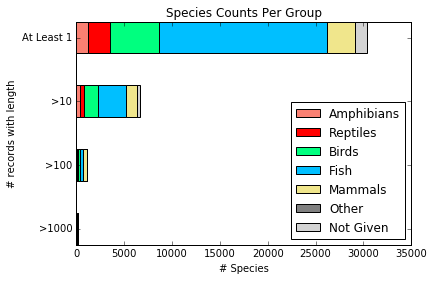

In [100]:
left = [0.0, 0.0, 0.0, 0.0]
fig, ax = plt.subplots()

for i in range(df.shape[0]):
    ax.barh(np.arange(4), df.iloc[i, 1:5], 0.5, left=left, label=df.iloc[i, 0], color=COLORS[i])
    left += df.iloc[i, 1:5]

ax.set_title('Species Counts Per Group')
ax.legend(loc='lower right')
ax.set_yticks(np.arange(4) + 0.25)
ax.set_yticklabels(labels=['>1000', '>100', '>10', 'At Least 1'])
ax.set_ylabel('# records with length')
ax.set_xlabel('# Species')
plt.show()

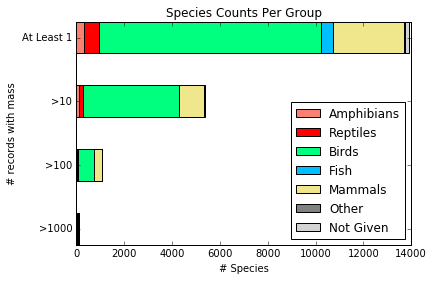

In [101]:
left = [0.0, 0.0, 0.0, 0.0]
fig, ax = plt.subplots()

for i in range(df.shape[0]):
    ax.barh(np.arange(4), df.iloc[i, 5:9], 0.5, left=left, label=df.iloc[i, 0], color=COLORS[i])
    left += df.iloc[i, 5:9]

ax.set_title('Species Counts Per Group')
ax.legend(loc='lower right')
ax.set_yticks(np.arange(4) + 0.25)
ax.set_yticklabels(labels=['>1000', '>100', '>10', 'At Least 1'])
ax.set_ylabel('# records with mass')
ax.set_xlabel('# Species')
plt.show()

Pie charts

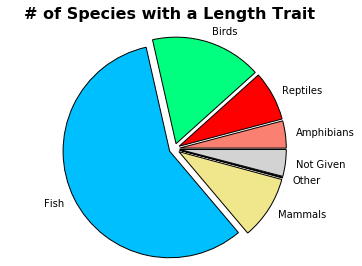

In [124]:
plt.suptitle('# of Species with a Length Trait', fontsize=16, weight='semibold', y=1)
plt.pie(df['total_length_0'], labels=df['group'], colors=COLORS, explode=np.array([0.05] * 7))
plt.axis('equal')
plt.show()

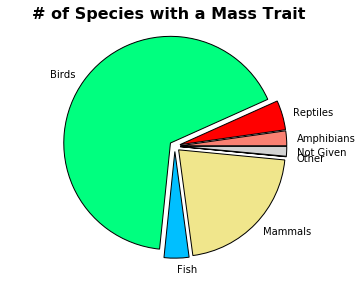

In [125]:
plt.suptitle('# of Species with a Mass Trait', fontsize=16, weight='semibold', y=1)
plt.pie(df['body_mass_0'], labels=df['group'], colors=COLORS, explode=np.array([0.05] * 7))
plt.axis('equal')
plt.show()

[top](#Table-of-Contents)